In [1]:
from alignment import Alignment, Camera, Photo,CalibrationSquareObservation
import numpy as np
from glob import glob
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline

class AlignmentMovingMarkers(Alignment):
    def getsecondsfromfn(self,fn):
        """Get number of seconds since midnight from filename, returns float"""
        timestring = re.findall('([0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{6})',fn)[0]
        hours,mins,secs = [float(st) for st in timestring.split(':')]
        return hours*3600+mins*60+secs

    def getintervalstarts(self,times,interval_length):
        """

        """
        intervals = []
        intervalstart = 0
        for t in sorted(times):
            if t>intervalstart+interval_length:
                intervals.append(t)
                intervalstart=t
        intervals.append(intervals[-1]+interval_length)
        intervals = np.array(intervals)
        return intervals

    def getalltimes(self,paths):
        alltimes = []
        for imgfiles in allimgfiles:
            for fn in imgfiles:
                alltimes.append(self.getsecondsfromfn(fn))
        return alltimes
    
    def getinterval(self,t):
        """
        Returns which interval index a given time is in.
        """
        try:
            interval = np.where(t>=self.intervals)[0][-1]
            if interval==len(self.intervals)-1:
                raise NotInIntervalException
        except IndexError as exc:
            raise NotInIntervalException from exc
        return interval
    
    def addmissingobs(self):
        for photo in self.photos:
            if len(photo.observations)==0:
                idx = photo.timeindex
                for same_idx_photo in self.photos:
                    if same_idx_photo.timeindex!=idx: continue
                    if len(same_idx_photo.observations)==0: continue
                    obs = CalibrationSquareObservation(same_idx_photo.observations[0].calsquare,photo)
                    photo.observations.append(obs)
                                    

    def __init__(self,allimgfiles,interval_length=1,xval=None):
        """
        Use this class if:
        - The cameras are stationary,
        - The code(s) move.
        Parameters:
        - allimgfiles is a list of lists of strings, each list is a single camera's photos.
            The code is assumed to be stationary within 'intervals', so we expect that two photos
            (taken by two cameras within interval_length are of code in the same location)
        - interval_length: how long an interval is (in seconds), default = 1
        """
        self.allimgfiles = allimgfiles
        #compute the start times of intervals
        times = self.getalltimes(allimgfiles) 
        self.intervals = self.getintervalstarts(times,interval_length)
        
        self.photos = []
        self.calsquares = {}
        self.cameras = []

        
        for imgi,imgfiles in enumerate(allimgfiles):
            cam = Camera()
            self.cameras.append(cam)
            for fn in imgfiles:
                interval = self.getinterval(self.getsecondsfromfn(fn))
                data = np.load(fn,allow_pickle=True)
                image = data['img'].astype(float)
                photo = Photo(cam,image,interval)
                photo.decode(self.calsquares,timeout=2000,max_count=1)
                self.photos.append(photo)
            
        
    def draw(self):
        for i in range(len(self.intervals)):
            for j in range(len(self.cameras)):
                plt.subplot(len(self.intervals),len(self.cameras),i*len(self.cameras)+j+1)
                for photo in self.photos:
                    if photo.camera == self.cameras[j]:
                        if photo.timeindex == i:     
                            photo.draw()
                            plt.xlim([0,2048])
                            plt.ylim([1536,0])    

In [2]:
paths = ['demo_sametag/cam1','demo_sametag/cam2']
allimgfiles = [sorted(glob(path+'/*.np'))[:8] for path in paths]
alignment = AlignmentMovingMarkers(allimgfiles)

In [3]:
alignment.firstpass()
alignment.secondpass()

1802890.7014855207
775847.8461160044
383172.41000587045
303194.1435880485
1298692924875042.5
6589.33963844784
657.6040002952086
507.32730171069494
507.23619738725984
507.2361973880531


In [4]:
alignment.addmissingobs()

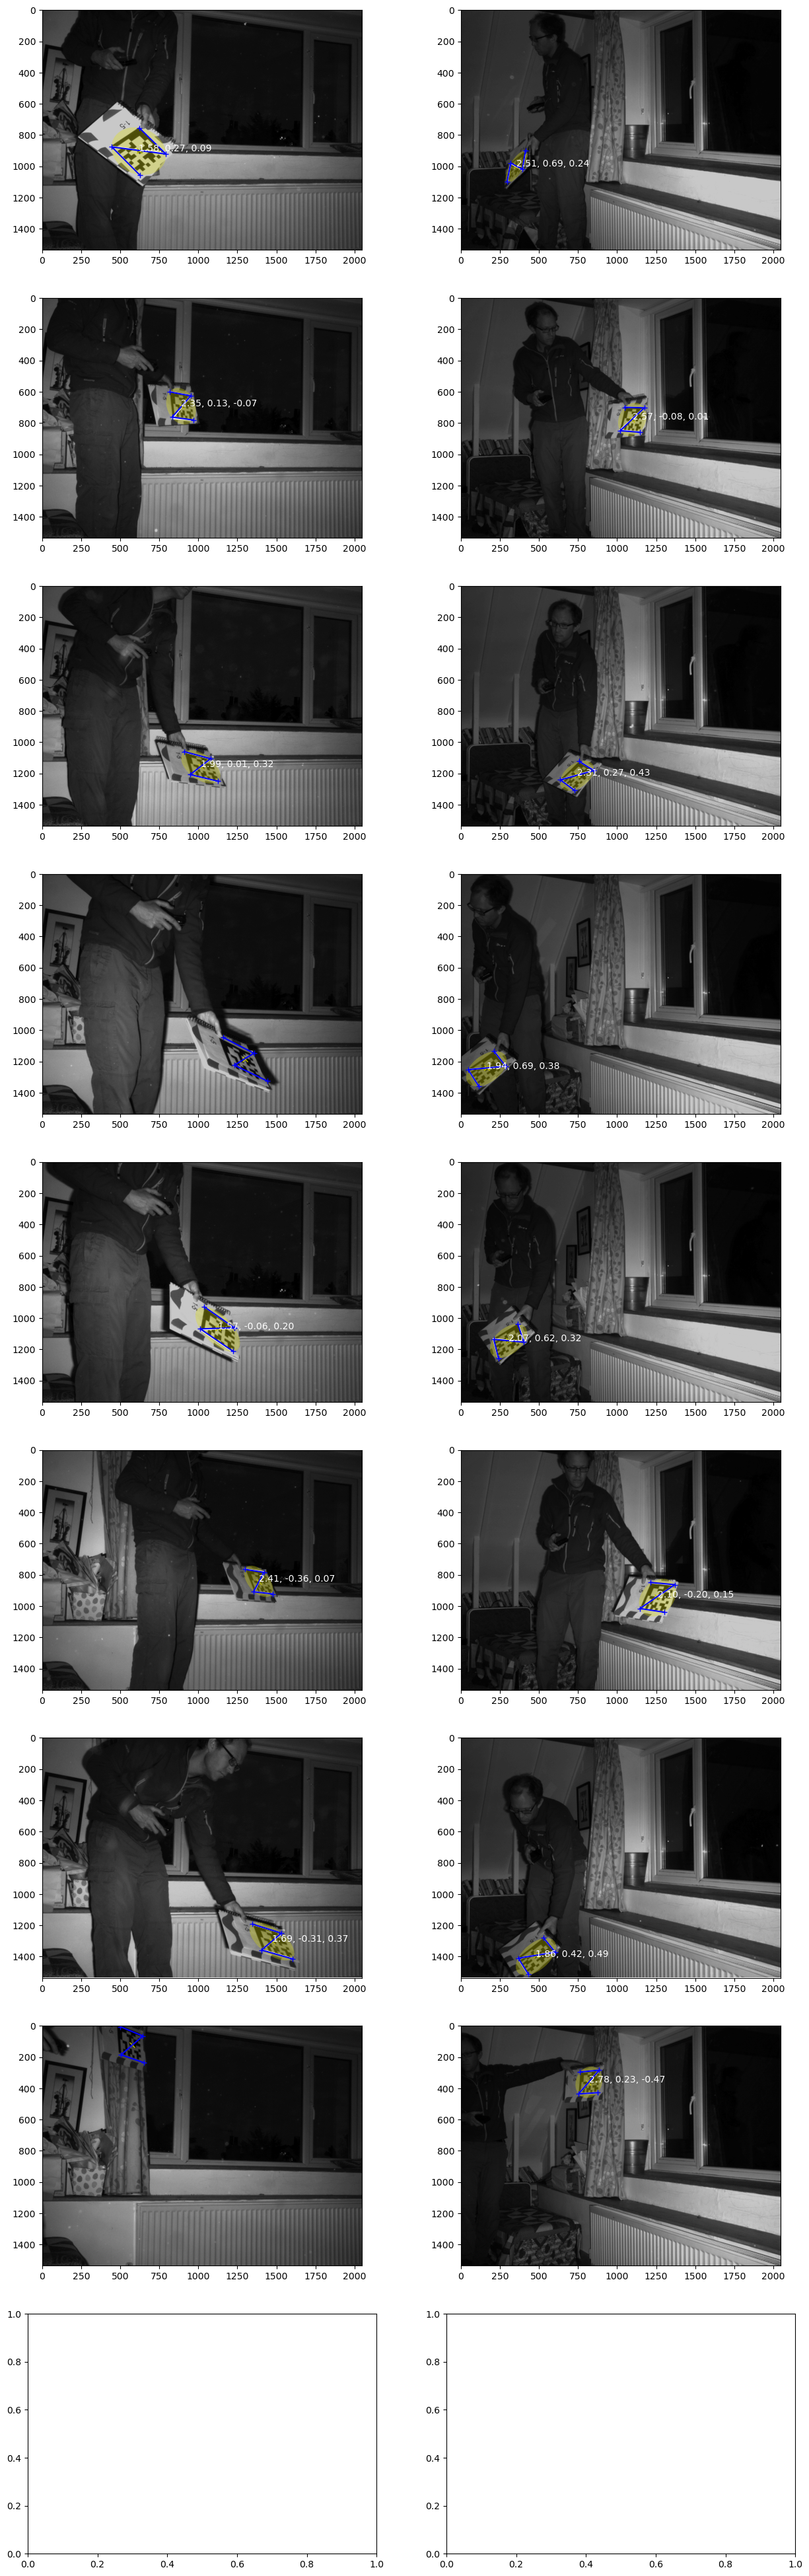

In [6]:
#plt.figure(figsize=[8,50])
plt.figure(figsize=[15,50])
alignment.draw()